In [1]:
import pandas as pd
import numpy as np
import os
import seaborn
from datetime import datetime
import time
import math
import matplotlib.pyplot as plt
import gc
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
import altair as alt

## Dataset import/cleaning

In [2]:
pb_only = False # SET TO TRUE TO USE ONLY PERSONAL BEST RECORDS

record_df = pd.DataFrame()
if not pb_only:
    # full record dataset
    record_df = pd.read_csv("out/all_records_pt_1.csv", index_col=[0])
    record_df = pd.concat([record_df, pd.read_csv("out/all_records_pt_2.csv", index_col=[0])], ignore_index=True)
else:
    # pb records only
    record_df = pd.read_csv("out/all_pbs.csv", index_col=[0])
    record_df = record_df.reset_index(drop=True)

# full user dataset
user_df = pd.read_csv("out/all_user_info.csv", index_col=[0])
user_df = user_df.reset_index(drop=True)

In [3]:
# construct more attributes
record_df["kps"] = record_df["inputs"] / (record_df["final_time"] / 1000) # keys per second
record_df["kpp"] = record_df["inputs"] / record_df["pieces_placed"] # keys per piece
record_df["percent_perf"] = record_df["finesse_perf"] / record_df["pieces_placed"] # percent of pieces placed with perfect finesse

In [4]:
# calculate time since account creation (users)
def calcTimePlayed(x):
    if x and isinstance(x, str):
        return time.time() - datetime.fromisoformat(x).timestamp()
    else:
        return math.nan
    
user_df["time_played"] = user_df["created_date"].apply(calcTimePlayed) # time since account creation

In [5]:
# drop the three records with over 5k finesse faults
crazy_outliers = record_df.loc[record_df["finesse_faults"] > 5000].index

for crazy_outlier in crazy_outliers:
    record_df = record_df.drop(crazy_outlier)

## Construct user attributes from records

In [6]:
# construct record-based user attrs
attrs_to_grab = ["final_time","pps","inputs","score","pieces_placed","singles","doubles","triples","quads","all_clears","finesse_faults","finesse_perf", "percent_perf", "kpp", "kps"]

for attr in attrs_to_grab:
    user_df = user_df.merge(record_df.groupby(by=["user_id"])[[attr]].mean().rename(columns={attr: attr+'_avg'}), left_on="id", right_on="user_id")

In [7]:
pb_record_df = record_df.loc[record_df["current_pb"] == True]
# explicitly delete and garbage-collect the records dataframe to reduce memory overhead
del record_df
gc.collect()

0

In [8]:
for attr in attrs_to_grab:
    user_df = user_df.merge(pb_record_df.groupby(by=["user_id"])[[attr]].max().rename(columns={attr: attr+'_pb'}), left_on="id", right_on="user_id")

In [9]:
# explicitly delete and garbage-collect the records dataframe to reduce memory overhead
del pb_record_df
gc.collect()

0

In [10]:
user_df = user_df.dropna()

In [11]:
user_df.columns

Index(['id', 'username', 'rank', 'cohort', 'best_time', 'best_record',
       'country', 'created_date', 'xp', 'achievement_rating',
       'TL_games_played', 'TL_games_won', 'TL_play_time', 'num_records',
       'time_played', 'final_time_avg', 'pps_avg', 'inputs_avg', 'score_avg',
       'pieces_placed_avg', 'singles_avg', 'doubles_avg', 'triples_avg',
       'quads_avg', 'all_clears_avg', 'finesse_faults_avg', 'finesse_perf_avg',
       'percent_perf_avg', 'kpp_avg', 'kps_avg', 'final_time_pb', 'pps_pb',
       'inputs_pb', 'score_pb', 'pieces_placed_pb', 'singles_pb', 'doubles_pb',
       'triples_pb', 'quads_pb', 'all_clears_pb', 'finesse_faults_pb',
       'finesse_perf_pb', 'percent_perf_pb', 'kpp_pb', 'kps_pb'],
      dtype='object')

## Begin k-means clustering

### Seperate and standardize desired features

### Optimize model

#### Select Features

To select the most useful features for the model while minimizing unnecessary computation, we created 38 models, each with a different feature removed. We then compared the resulting evaluation metric (see below) value for each model, and selected only those values which *improve* the accuracy of the model.

Our selected evaluation metric was the correlation between each row's `rank` and the centroid `rank` of its assigned cluster.

The following features were selected for removal: `'TL_games_won', 'singles_avg', 'singles_pb', 'triples_avg', 'finesse_perf_avg', 'doubles_pb', 'inputs_avg', 'triples_pb', 'quads_pb'`

![cluster feature selection](cluster_feature_selection.png)

In [12]:
feature_corrs = user_df.corr(numeric_only=True)['rank']

In [13]:
feature_corrs = feature_corrs.apply(abs).sort_values(ascending=False).drop(['best_time', 'cohort'])
feature_corrs

rank                  1.000000
final_time_pb         0.956077
final_time_avg        0.921226
pps_pb                0.854651
pps_avg               0.845298
kps_pb                0.812346
kps_avg               0.794003
inputs_pb             0.685606
finesse_faults_pb     0.663151
inputs_avg            0.641337
kpp_pb                0.636390
finesse_faults_avg    0.627951
kpp_avg               0.598142
percent_perf_pb       0.591347
percent_perf_avg      0.553843
finesse_perf_pb       0.542832
finesse_perf_avg      0.513487
score_avg             0.477647
pieces_placed_pb      0.476127
pieces_placed_avg     0.459556
score_pb              0.416299
quads_avg             0.411330
quads_pb              0.392024
singles_avg           0.362735
TL_play_time          0.347391
singles_pb            0.339374
TL_games_won          0.338026
xp                    0.328062
TL_games_played       0.325672
achievement_rating    0.318427
doubles_avg           0.317206
doubles_pb            0.268269
num_reco

In [ ]:
# scores = {}
# for feature in feature_corrs.index:
#     print("Evaluating removal of",feature)
#     features_to_use = list(feature_corrs.index)
#     features_to_use.remove(feature)
#     # print(features_to_use)

#     features = user_df.loc[:,features_to_use].values
#     scaler = StandardScaler()
#     scaled_features = scaler.fit_transform(features)

#     model = KMeans(init="random", n_clusters=20, random_state=25) # using only 20 clusters for efficiency
#     model.fit(scaled_features)

#     # extract the rank value for each cluster center
#     rank_centers = [cluster[0] for cluster in model.cluster_centers_]

#     # map cluster labels for each object to rank values, then compare to actual rank values
#     scores[feature] = abs(np.corrcoef(user_df['rank'].values, np.array([rank_centers[x] for x in model.labels_]))[0,1])
    # print(scores[len(scores)-1])
    

In [ ]:
# features_to_use = list(feature_corrs.index)
# # print(features_to_use)

# features = user_df.loc[:,features_to_use].values
# scaler = StandardScaler()
# scaled_features = scaler.fit_transform(features)

# model = KMeans(init="random", n_clusters=20, random_state=25) # using only 20 clusters for efficiency
# model.fit(scaled_features)

# # extract the rank value for each cluster center
# rank_centers = [cluster[0] for cluster in model.cluster_centers_]

# # map cluster labels for each object to rank values, then compare to actual rank values
# full_set_score = abs(np.corrcoef(user_df['rank'].values, np.array([rank_centers[x] for x in model.labels_]))[0,1])

In [ ]:
# full_set_score

np.float64(0.9022180525388708)

In [ ]:
# scores = {key: value for key, 
#                value in sorted(scores.items(), 
#                                key=lambda item: float(item[1]))}

# score_df = pd.DataFrame({'keys': scores.keys(), 'score': scores.values()})

# dots = alt.Chart(score_df).mark_circle().encode(
#     x=alt.X('keys',title="Feature Removed"),
#     y=alt.Y('score', scale=alt.Scale(domainMax=0.952, domainMin=0.865), title="Rank Correlation Score"),
#     tooltip=['keys', 'score']
# ).interactive()

# line = alt.Chart(score_df).mark_line().encode(
#     x='keys',
#     y=alt.Y('score', title="")
# )
# # 0.9018246020254752
# full = alt.Chart(pd.DataFrame({'y': [full_set_score]})).mark_rule(color='black').encode(
#     y=alt.Y('y', title="")
# )
# cutoff = alt.Chart(pd.DataFrame({'y': [full_set_score*1.004]})).mark_rule(color='red').encode(
#     y=alt.Y('y', title="")
# )

# final = alt.Chart(pd.DataFrame({'y': [0.9468358969096532]})).mark_rule(color='green').encode(
#     y=alt.Y('y', title="")
# )

# dots+line+full+cutoff+final

alt.LayerChart(...)

#### For number of clusters

The optimal number of clusters was selected by comparing the inertia (WCSS) of the model for a range of cluster counts:

![image](cluster_optimization.png)

A cluster count of 50 was selected to balance accuracy with computing time.

In [ ]:
# THIS CELL WILL TAKE OVER 80min TO RUN

# dists = []
# for i in range(1,60):
#     model = KMeans(init="random", n_clusters=i)
#     model.fit(scaled_features)
#     dists.append(model.inertia_) # builtin euclidian distance

In [ ]:
# dist_df = pd.DataFrame({'n_clusters': range(1, len(dists)+1), 'dist': dists})

# dots = alt.Chart(dist_df).mark_circle().encode(
#     x='n_clusters',
#     y='dist',
#     tooltip=['n_clusters', 'dist']
# ).interactive()

# line = alt.Chart(dist_df).mark_line().encode(
#     x='n_clusters',
#     y='dist'
# )

# dots+line

### Build final model

In [31]:
# select the final feature set
features = user_df.loc[:, ['rank', 'kps_pb', 'final_time_pb', 'kps_avg', 'final_time_avg', 'pps_pb', 'pps_avg', 'achievement_rating', 'xp', 'all_clears_avg', 'all_clears_pb', 'TL_play_time', 'TL_games_played', 'TL_games_won', 'time_played', 'num_records', 'inputs_pb', 'kpp_pb', 'score_pb', 'score_avg', 'finesse_faults_pb', 'percent_perf_pb', 'doubles_avg', 'finesse_perf_pb', 'doubles_pb', 'kpp_avg', 'finesse_faults_avg', 'inputs_avg', 'pieces_placed_pb']].values
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [32]:
# this cell will take over 1min to run

model = KMeans(init="random", n_clusters=50, random_state=25)
model.fit(scaled_features)

KMeans(init='random', n_clusters=50, random_state=25)

In [ ]:
model.cluster_centers_

In [33]:
# extract the rank value for each cluster center
rank_centers = [cluster[0] for cluster in model.cluster_centers_]

# map cluster labels for each object to rank values, then compare to actual rank values
final_score = abs(np.corrcoef(user_df['rank'].values, np.array([rank_centers[x] for x in model.labels_]))[0,1])
print(final_score)

0.9468358969096532


## Analysis of clusters

In [42]:
# copy clusters into the users DF
user_df["cluster"] = model.labels_
user_df.head()

,id,username,rank,cohort,best_time,best_record,country,created_date,xp,achievement_rating,...,doubles_pb,triples_pb,quads_pb,all_clears_pb,finesse_faults_pb,finesse_perf_pb,percent_perf_pb,kpp_pb,kps_pb,cluster
0,62a51397bf6ce5ce2e84b6cd,westl,1,13,13430.000000,66c273ca024b9a580d3c56a4,US,2022-06-11T22:13:43.355Z,1.236330e+07,445,...,5,0,6,1,0.0,101.0,1.000000,3.029703,22.784810,2
1,5e89fca2fd676e407898adbe,fortissim2,2,14,14008.333333,669633fe831a250b87499856,CA,2020-04-05T15:43:30.457Z,1.230626e+07,359,...,3,0,8,0,0.0,101.0,1.000000,2.534653,18.274836,24
3,5e7cbb652932b46c9c671ce4,icly,4,14,14385.000000,669d146c27be3114bd427572,VA,2020-03-26T14:25:41.228Z,1.347776e+07,251,...,0,0,10,0,1.0,100.0,0.990099,2.603960,18.282934,2
4,6030455395d4a33b1b6831bc,master101,5,14,14525.000000,6695d06c831a250b87faeb51,US,2021-02-19T23:10:11.728Z,1.776228e+07,273,...,0,1,9,0,2.0,100.0,0.990099,2.613861,18.175559,2
5,5f5dbcc4454e942b4fdfc5fa,vincehd,6,14,14531.666667,66963653831a250b874b753b,PH,2020-09-13T06:31:32.291Z,2.259369e+07,448,...,5,1,5,0,2.0,101.0,0.980583,2.485437,17.616699,32


### Visualization

In [43]:
# seaborn.heatmap(user_df.corr(numeric_only=True), cmap="icefire", center=0, vmin=-1, vmax=1).set(title="Correlation between user attributes")

In [44]:
corr = user_df.corr(numeric_only=True)

In [45]:
cluster = alt.Chart(corr.drop("cluster", axis=0).reset_index(), title="Correlation to Cluster").mark_rect().encode(
    x='index',
    tooltip='cluster',
    color=alt.Color('cluster').scale(scheme='redblue')
).interactive()

best = alt.Chart(corr.drop("best_time", axis=0).reset_index(), title="Best Time").mark_rect().encode(
    x='index',
    tooltip='cluster',
    color=alt.Color('best_time').scale(scheme='redblue')
).interactive()

cluster# & best

alt.Chart(...)

In [46]:
# cluster25dist_square = euclidean_distances(user_df.select_dtypes(include=np.number).loc[user_df["cluster"] == 25])
# cluster25dist = []
# for rowDist in cluster25dist_square:
#     cluster25dist.append(math.sqrt(sum(rowDist)))
# sum(cluster25dist)/len(cluster25dist)

In [47]:
alt.Chart(user_df.sample(1000), title="Rank by Cluster").mark_circle().encode(
    x=alt.X("cluster", title="Cluster (non-ordered categories)"),
    y=alt.Y("rank", title="Rank"),
    color=alt.Color("cluster", title="Cluster").scale(scheme="turbo"),
    tooltip=["username", "cohort", "cluster"]
).interactive()

alt.Chart(...)

In [48]:
cluster_avgs = user_df.select_dtypes(include=np.number).groupby('cluster').mean().reset_index()
cluster_avgs.head()

,cluster,rank,cohort,best_time,xp,achievement_rating,TL_games_played,TL_games_won,TL_play_time,num_records,...,singles_pb,doubles_pb,triples_pb,quads_pb,all_clears_pb,finesse_faults_pb,finesse_perf_pb,percent_perf_pb,kpp_pb,kps_pb
0,0,208716.047221,88.906681,89408.199738,3.438718e+05,2.422151,349.626255,147.417815,1.107784e+05,13.900880,...,15.119830,5.573857,1.704260,2.174381,0.000437,137.932381,45.454806,0.435225,4.612693,5.446272
1,1,424894.750902,122.495564,122993.146632,2.446034e+05,2.712294,245.057132,96.430535,8.006772e+04,10.506776,...,15.970752,5.242566,1.427708,2.144974,1.025349,126.293068,52.778493,0.501727,4.508419,4.159278
2,2,20452.825961,37.898477,38389.170897,1.323133e+07,104.702683,8515.637418,3498.629442,3.519173e+06,99.559826,...,6.162437,1.940537,0.628716,6.583756,0.153009,25.520667,85.741117,0.836440,3.360441,9.955308
3,3,926530.851002,231.971304,232470.384532,4.280262e+04,0.305620,55.003486,15.213670,1.625314e+04,4.020919,...,18.419409,4.329872,1.908203,1.859201,0.006168,308.365350,23.030152,0.210938,6.297377,3.013743
4,4,99277.312693,63.100619,63599.521844,1.159518e+06,19.064499,898.186791,402.888029,3.612108e+05,21.780702,...,7.444788,3.404541,0.581527,2.365841,1.764190,33.325593,86.144995,0.824801,3.833134,7.142127


In [49]:
# THIS CELL WILL TAKE OVER 3MIN TO RUN
# seaborn.pairplot(cluster_avgs)

[Text(0.5, 1.0, 'Correlation between cluster attributes')]

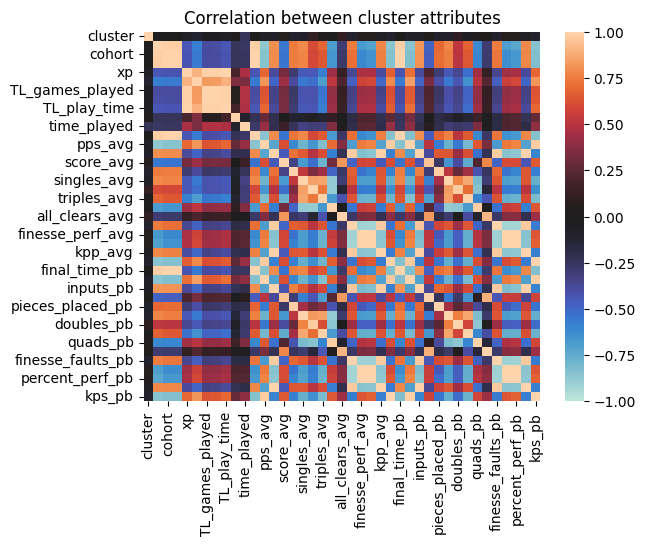

In [50]:
seaborn.heatmap(cluster_avgs.corr(numeric_only=True), cmap="icefire", center=0, vmin=-1, vmax=1).set(title="Correlation between cluster attributes")

In [51]:
alt.Chart(cluster_avgs).mark_circle().encode(
    x="cluster",
    y="percent_perf_pb",
    color=alt.Color("rank").scale(scheme="turbo", reverse=True),
    tooltip=["cluster", "rank"]
).interactive()

alt.Chart(...)

### Make recommendations based on cluster

In [52]:
def calc_attr_dist(user, bestUser, means):
    dists = {}
    for attr in user.index:
        dist = (user[attr]) - (bestUser[attr])
        dist = dist / means[attr]
        dists[dist] = attr #math.sqrt((user[attr] - bestUser[attr])**2)
    return dists

In [57]:
improveable_attrs = {
    'num_records': "number of 40-lines games played", 
    'pps_pb': "number of pieces placed per second (PPS)",
    'inputs_pb': "number of inputs", 
    'score_pb': "score",  
    'percent_perf_pb': "percent of pieces placed with perfect finesse (finesse %)", 
    'kpp_pb': "number of keys pressed per piece (KPP)", 
    'kps_pb': "number of keys pressed per second (KPS)"
    }
def suggest_improvement(username):
    user = user_df.loc[user_df["username"] == username].reset_index().loc[0]
    userCluster = user_df.loc[user_df["cluster"] == user["cluster"]]
    bestUser = userCluster.loc[userCluster["rank"] == userCluster["rank"].min()].reset_index().loc[0]
    # worstUser = userCluster.loc[userCluster["rank"] == userCluster["rank"].max()].reset_index().loc[0]
    print("You are in cluster", user["cluster"])
    print("The top user in this cluster is", bestUser['username'],"with a rank of", bestUser['rank'], "\n")
    # dist_from_best = euclidean_distances(np.array(user.iloc[np.append(np.arange(9,47), [3,4,5])].T).reshape(1,-1), np.array(bestUser.iloc[np.append(np.arange(9,47), [3,4,5])].T).reshape(1,-1))
    # print(dist_from_best)
    dists = calc_attr_dist(user[improveable_attrs.keys()], bestUser[improveable_attrs.keys()], userCluster[improveable_attrs.keys()].mean())
    min_dist = dists[min(dists.keys())]
    max_dist = dists[max(dists.keys())]
    closest_zero = dists[min(dists.keys(), key=lambda x: abs(x))]
    print("You and", bestUser["username"], "have a similar", improveable_attrs[closest_zero])
    print("Your", improveable_attrs[max_dist],"is higher than", bestUser["username"]+"'s")
    print("Your", improveable_attrs[min_dist],"is lower than", bestUser['username']+"'s")
    # print(min_dist, max_dist, closest_zero)
    # return dists

In [58]:
suggest_improvement('tigerros')

You are in cluster 13
The top user in this cluster is meppydc with a rank of 107 

You and meppydc have a similar score
Your number of inputs is higher than meppydc's
Your number of pieces placed per second (PPS) is lower than meppydc's


In [59]:
suggest_improvement('badwolf5940')

You are in cluster 34
The top user in this cluster is calciumdeficit with a rank of 83 

You and calciumdeficit have a similar number of keys pressed per piece (KPP)
Your number of inputs is higher than calciumdeficit's
Your number of pieces placed per second (PPS) is lower than calciumdeficit's


In [56]:
for usr in user_df[['username', 'rank']].sample(10).reset_index().iterrows():
    print("\n---\nSampling", usr[1]['username']+": rank", usr[1]['rank'], "\n")
    suggest_improvement(usr[1]['username'])


---
Sampling nichiko: rank 414892 

You are in cluster 23
The top user in this cluster is anggarrr with a rank of 24950 

You and anggarrr have a similar number of pieces placed per game
Your number of inputs is higher than anggarrr's
Your number of 40-lines games played is lower than anggarrr's

---
Sampling pussylesbian: rank 629955 

You are in cluster 19
The top user in this cluster is andy0903 with a rank of 182230 

You and andy0903 have a similar score
Your number of inputs is higher than andy0903's
Your number of pieces placed per second (PPS) is lower than andy0903's

---
Sampling deyvid5: rank 671470 

You are in cluster 35
The top user in this cluster is ssmaster with a rank of 180276 

You and ssmaster have a similar score
Your number of inputs is higher than ssmaster's
Your number of 40-lines games played is lower than ssmaster's

---
Sampling xxh3r0xx: rank 751711 

You are in cluster 43
The top user in this cluster is timmythepro with a rank of 227990 

You and timmythe